# Fine-Tune Segment Anything Model (SAM)

Author: Evan Hann

Date Created: 10th September 2023

# Introduction

Segment Anything Model (SAM), developed by Meta AI Research, was trained on an enormous dataset of 11 million images of everyday objects and scenes to predict high-quality segmentation masks. As demonstrated in the <a href="https://github.com/ev-h/segment-anything-mri/blob/main/notebooks/SAM_demo_cardiac_MRI.ipynb">previous notebook</a>, there is great potential to adapt SAM for medical image segmentation due to its zero-shot capability. 

However, SAM may not always give the desired segmentation. As observed in the previous notebook, it is possible for SAM to segment a different anatomical region (the epicardium) instead of the one we are actually interested in (the endocardium) in the single output setting. It is necessary to retrain SAM with additional data if we want to fine-tune it for segmentation of a specific region of interest (the endocardium). 

In this notebook, we will explore how to customize SAM and perform retraining. We cannot use ```SamPredictor``` directly as the ```torch.no_grad()``` decorator around the ```predict_torch``` method prevents generating gradients for updating the model. In addition, the non-differentiable comparison operator for mask thresholding in the ```predict_torch``` method would also be an obstacle. To mitigate these issues, we will create a CustomizedSam class with a modified ```predict``` method that enables retraining. More specifically, we are fine-tuning only the mask decoder, and freezing the image encoder and the prompt encoder. As the mask decoder is light-weight compared to the image encoder, it could be more efficient to fine-tune the decoder alone.

In [12]:
from segment_anything import sam_model_registry, SamPredictor
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../utils")

# Load and Prepare Data

## Download the SunnyBrook Data
In this notebook, we demonstrate fine-tuning SAM for the endocardium segmentation using the SunnyBrook dataset, which can be downloaded from <a href="https://www.cardiacatlas.org/sunnybrook-cardiac-data/">here</a>. We specify the SunnyBrook data directory path below.

In [5]:
# Specify the SunnyBrook data directory path
DATA_ROOT = "../../../sunnybrook_data/"

## Create DataFrame

```SunnyBrookDataFrames``` is imported from the utils directory to parse the SunnyBrook data directory and generate a data frame of input images matched with ground truth contours. To avoid data leakage, we will remove cases with PatientID "SCD0000101" as these are from the same patient as the demo data. Then we can use ```train_test_split``` to randomly sample a subset of the data for training.

In [25]:
# This module is located in the utils directory
from dataframes import SunnyBrookDataFrames

sunnybrook_dfs = SunnyBrookDataFrames(DATA_ROOT)
df = sunnybrook_dfs.get_merged_df()
print(len(df), "rows in df")

804 rows in df


In [26]:
from sklearn.model_selection import train_test_split

# Remove cases that belong to the same patient of the demo data to avoid data leakage
dev_df = df[df["PatientID"]!="SCD0000101"]
train_df, test_df = train_test_split(dev_df, test_size=0.2)
print(len(train_df), "rows in train_df")

628 rows in train_df


# Preprocessing

Unlike everyday color images, cardiac MRI cine is usually in gray scale, without color (RGB) channels. In this case, we artificially add RGB channels to the medical image to make the image compatible with SAM, which is designed to handle everyday color images. This can be done by stacking copies of the same medical image together.

Another issue is that SAM supports uint8 pixel dtype but not uint16 (used in the medical image). Simply doing ```image = image.astype("uint8")``` could severely affect the image quality. We need to linearly rescale the image intensity to 0-255 range. 

In addition, image cropping can influence segmentation prediction by SAM. In this notebook, the image is cropped to 150 by 150 pixels around the heart.

One more thing - the image is rotated 90 degrees clockwise so that the right ventricle is on the <i>right</i> side!

In [34]:
def preprocess_image(image, to_rgb=True, to_uint8=True, rot90=True):
    # Add RGB channels
    if to_rgb:
        image = np.stack((image, image, image), axis=-1)

    # Convert image from uint16 to uint8
    if to_uint8:
        _min, _max = np.min(image), np.max(image)
        image = (image - _min)/(_max - _min)*255
        image = image.astype("uint8")

    # Rotate 90 degrees clockwise
    if rot90:
        image = np.rot90(image, k=3)

    return image

## Create PyTorch Dataset and Dataloader

In PyTorch, it is common practice to implement a ```Dataset``` class and instantiate a ```DataLoader``` to manage data loading and preparation.

In [ ]:
from torch.utils.data import Dataset, DataLoader

# This module is located in the utils directory
from image_contour_io import ImageContourPair

class SunnyBrookDataset(Dataset):
    def __init__(self, sunnybrook_df):
        self.df = sunnybrook_df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_ctr_pair = ImageContourPair(row["ImageFilePath"], row["ContourFilePath"])

        image = img_ctr_pair.get_cropped_image()
        mask = img_ctr_pair.get_cropped_mask()

        image = preprocess_image(image)
        mask = preprocess_image(mask, to_rgb=False, to_uint8=False, rot90=True)

        return image.astype(float), mask.copy()

In [10]:
dataset = SunnyBrookDataset(train_df)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

# Fine-Tune SAM

## Load the pretrained SAM model

Once we have the data ready, we load the pretrained SAM model. If not done yet, we can download a SAM checkpoint from <a href="https://github.com/facebookresearch/segment-anything#model-checkpoints">the SAM repo</a> and assign the downloaded .pth file path to ```sam_checkpoint```. Don't forget to also set the correct ```model_type``` and ```device```.

In [28]:
sam_checkpoint = "../../sam_checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

## SAM Segmentation before Fine-Tuning

We set ```multiple_output``` to ```False``` to generate a single segmentation mask instead. This is useful for applications where we are interested in only a single region (e.g. the endocardium). However, SAM may not know which region to segment especially if an input seed point is ambiguous - a seed point in the center of the left ventricle is valid for both the endocardium and the epicardium. Before fine-tuning, it is possible for SAM to output the epicardium mask (as shown in the figure below) even if we are actually interested in the endocardium.

In [39]:
def load_dicom_image(dcm_file_path):
    ds = pydicom.dcmread(dcm_file_path)
    image = ds.pixel_array
    return image

def show_mask(mask, ax, color):
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker='*', s=marker_size, edgecolor="white", linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker='*', s=marker_size, edgecolor="white", linewidth=1.25)

In [35]:
dcm_file_path = "../demo_data/scd-image.dcm"
image = load_dicom_image(dcm_file_path)
image = preprocess_image(image)
image = image[50:200, 50:200, :]

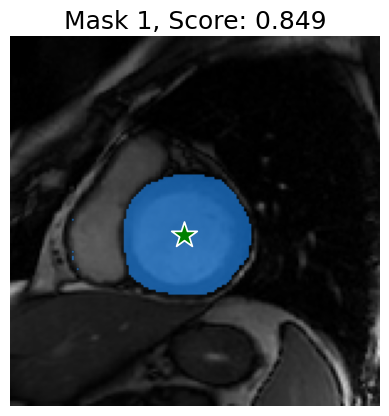

In [40]:
sam_predictor.set_image(image)
input_point = np.array([[70, 80]])
input_label = np.array([1])
mask_color = np.array([.12, .56, 1., 0.6])

masks, scores, logits = sam_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False, # set to False to output a single segmentation mask
)

for i in range(1):
    plt.imshow(image)
    show_mask(masks[i,:,:], plt.gca(), mask_color)
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {scores[i]:.3f}", fontsize=18)
    plt.axis("off")
    plt.show()

## Customize SAM to enable retraining

We cannot use ```SamPredictor``` directly as the ```torch.no_grad()``` decorator around the ```predict_torch``` method prevents generating gradients for updating the model. In addition, the non-differentiable comparison operator for mask thresholding in the ```predict_torch``` method would also be an obstacle. To mitigate these issues, we will create a CustomizedSam class with a modified ```predict``` method that enables retraining. More specifically, we are fine-tuning only the mask decoder, and freezing the image encoder and the prompt encoder. As the mask decoder is light-weight compared to the image encoder, it could be more efficient to fine-tune the decoder alone. The image encoder and the prompt encoder forward passes are enclosed by ```with torch.no_grad()``` so that back propagation will not update their weights.

In [41]:
import torch
from torch.nn.functional import threshold, normalize

class CustomizedSam:
    def __init__(self, sam_predictor, device):
        self.predictor = sam_predictor
        self.device = device
        self.input_point = np.array([[75, 75]])
        self.input_label = np.array([1])
        self.optimizer = None

    def predict(self, images):
        batch_size = images.shape[0]
        original_image_size = images.shape[1:3]

        input_images_torch = torch.as_tensor(images, dtype=torch.float32, device=self.device)
        input_images_torch = input_images_torch.permute(0, 3, 1, 2).contiguous() # tensor shape: (B, C, H, W)
        input_images_torch = self.predictor.transform.apply_image_torch(input_images_torch)
        input_images_torch = torch.stack([self.predictor.model.preprocess(input_images_torch[i,:,:,:]) for i in range(batch_size)], dim=0)

        point_coords = self.predictor.transform.apply_coords(self.input_point, original_image_size)
        coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=self.device)
        labels_torch = torch.as_tensor(self.input_label, dtype=torch.int, device=self.device)
        coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]

        with torch.no_grad(): # Not updating parameters in image_encoder and prompt_encoder
            image_embeddings = self.predictor.model.image_encoder(input_images_torch)
            sparse_embeddings, dense_embeddings = self.predictor.model.prompt_encoder(
                points=(coords_torch, labels_torch),
                boxes=None,
                masks=None,
            )

        positional_encodings = self.predictor.model.prompt_encoder.get_dense_pe()

        binary_masks = []
        for idx in range(batch_size):
            low_res_masks, iou_predictions = self.predictor.model.mask_decoder(
                image_embeddings=image_embeddings[idx:idx+1, :, :, :],
                image_pe=positional_encodings,
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )

            upscaled_masks = self.predictor.model.postprocess_masks(
                low_res_masks,
                input_images_torch.shape[-2:],
                original_image_size
            ).to(self.device)

            binary_masks.append(normalize(threshold(upscaled_masks, 0.0, 0)).to(self.device))

        return torch.cat(binary_masks, dim=0)


    def convert_gt_mask_to_tensor(self, mask):
        mask_torch = torch.as_tensor(mask, dtype=torch.float32, device=self.device)
        mask_torch = mask_torch.unsqueeze(1)
        return mask_torch

    def get_optimizer(self):
        if self.optimizer is None:
            self.optimizer = torch.optim.Adam(
                self.predictor.model.mask_decoder.parameters(),
                lr=1e-5,
                weight_decay=1e-9)
        return self.optimizer

    def train(self):
        self.predictor.model.train()

customized_sam = CustomizedSam(sam_predictor, device)

## Training Loop

After customizing SAM, we can start the training process. As SAM is a large model, it is time-consuming and resource-intensive to train. In this notebook, we demontrate the training with only one epoch, which can take about half an hour to run on a T4 GPU. After that, we will save the model state and reload it using ```SamPredictor```. Then we check if the fine-tuned SAM can give the desired output. 

In [ ]:
from tqdm import tqdm

num_epochs = 1

customized_sam.train()
bce_loss = torch.nn.BCELoss()
optimizer = customized_sam.get_optimizer()

for epoch in range(num_epochs):
    for images, truth_masks in tqdm(dataloader):
        truth_masks_torch = customized_sam.convert_gt_mask_to_tensor(truth_masks)
        pred_masks_torch = customized_sam.predict(images)

        loss = bce_loss(pred_masks_torch, truth_masks_torch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


torch.save(customized_sam.predictor.model.state_dict(),
           "../../sam_checkpoints/sam_vit_h_4b8939_fine-tuned.pth")

  0%|          | 0/628 [00:00<?, ?it/s]

## Sam Segmentation after Fine-Tuning

After fine-tuning SAM, we load the saved check point into ```SAMPredictor``` and perform a prediction on the demo data. The fine-tuned SAM outputs a desired segmentation for the endocardium. 

In [14]:
new_sam_checkpoint = "../../sam_checkpoints/sam_vit_h_4b8939_fine-tuned.pth"
new_sam = sam_model_registry[model_type](checkpoint=new_sam_checkpoint)
new_sam.to(device=device)
new_sam_predictor = SamPredictor(new_sam)

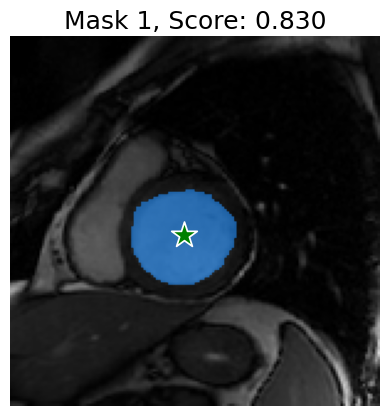

In [43]:
new_sam_predictor.set_image(image)

masks, scores, logits = new_sam_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False, # set to False to output a single segmentation mask
)

for i in range(1):
    plt.imshow(image)
    show_mask(masks[i,:,:], plt.gca(), mask_color)
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {scores[i]:.3f}", fontsize=18)
    plt.axis("off")
    plt.show()